In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [24]:
from june import World 
from june.demography.geography import Geography
from june.demography import Demography
from june.interaction import ContactAveraging
from june.infection import Infection
from june.infection.symptoms import SymptomsConstant
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries
from june.groups.leisure import Cinemas, Pubs, Groceries
from june.simulator import Simulator
from june.seed import Seed
from june import paths
from june.logger.read_logger import ReadLogger
from june.logger.read_light_logger import ReadLightLogger

from june.infection.infection import InfectionSelector
from june.world import generate_world_from_hdf5

# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [5]:
%%time
geography = Geography.from_file({
                                "super_area":  ["E02002512", "E02001697"]
                                          #["E02001720",
                                          #"E00088544", 
                                          #"E02002560", 
                                          #"E02002559"]
                                }
                                )

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
demography = Demography.for_geography(geography)
world = World(geography, demography, include_households=True)

2020-06-08 16:23:09,680 - june.demography.geography - INFO - There are 43 areas and 2 super_areas in the world.
2020-06-08 16:23:09,708 - june.groups.hospital - INFO - There are 1 hospitals in this geography.
2020-06-08 16:23:09,839 - june.groups.school - INFO - There are 5 schools in this geography.
2020-06-08 16:23:09,886 - june.groups.school - INFO - No school for the age 0 in this world.
2020-06-08 16:23:09,896 - june.groups.school - INFO - No school for the age 1 in this world.
2020-06-08 16:23:09,913 - june.groups.school - INFO - No school for the age 2 in this world.
2020-06-08 16:23:10,016 - june.groups.school - INFO - No school for the age 19 in this world.
2020-06-08 16:23:10,608 - june.groups.carehome - INFO - There are 43 care_homes in this geography.
populating the world's geography with the specified demography...
2020-06-08 16:23:33,931 - june.distributors.worker_distributor - INFO - There are 0 who had to be told to stay real
CPU times: user 25.2 s, sys: 2.56 s, total: 

### If it took a long time to run the previous command, it might be a good idea to save the world to reuse it later.

In [6]:
#world.to_hdf5("world.hdf5")

If we would like to load the world we saved, we just do

In [7]:
#world = generate_world_from_hdf5("world.hdf5")

you have now a beautiful pre-pandemic world. 

## Commute, travel and leisure

We can add cinemas, pubs, groceries, etc. as well as commute in major cities with

In [8]:
# leisure
world.cinemas = Cinemas.for_geography(geography)
world.pubs = Pubs.for_geography(geography)
world.groceries = Groceries.for_super_areas(world.super_areas,
                                            venues_per_capita=1/500)

In [9]:
# commute
world.initialise_commuting()

We are also going to need some cemeteries...geography.cemeteries = Cemeteries()


In [10]:
world.cemeteries = Cemeteries()

# Adding the infection

Now, you can play around with different models of infections. The building blocks for an infection are: Transmission and Symptoms. For now, only SymptomsConstant and TransmissionConstant are in a state to be used.

In [11]:
selector = InfectionSelector.from_file()

In [12]:
selector

# Adding the interaction

In [13]:
interaction = ContactAveraging.from_file(selector=selector)
#interaction = DefaultInteraction.from_file(selector=selector)

Beta are the intensities of the interaction taking place at the different groups

In [14]:
interaction.beta

{'box': 1,
 'pub': 0.1,
 'grocery': 0.1,
 'cinema': 0.1,
 'commute_unit': 0.5,
 'commute_city_unit': 0.5,
 'hospital': 0.5,
 'care_home': 0.5,
 'company': 0.5,
 'school': 0.5,
 'household': 0.5}

to modify these, simply do

In [15]:
interaction.beta['household'] *= 2

In [16]:
interaction.beta

{'box': 1,
 'pub': 0.1,
 'grocery': 0.1,
 'cinema': 0.1,
 'commute_unit': 0.5,
 'commute_city_unit': 0.5,
 'hospital': 0.5,
 'care_home': 0.5,
 'company': 0.5,
 'school': 0.5,
 'household': 1.0}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [17]:
interaction.alpha_physical

2.0

In [18]:
interaction.alpha_physical /= 2

In [19]:
interaction.alpha_physical

1.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [20]:
seed = Seed(world.super_areas, selector,)

In [21]:
n_cases = 50
seed.unleash_virus(n_cases) # play around with the initial number of cases

# Run the simulation

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [22]:
CONFIG_PATH = "../configs/config_example.yaml"

simulator = Simulator.from_file(
     world, interaction, selector, 
    config_filename = CONFIG_PATH
)

In [23]:
%%time
simulator.run()

2020-06-08 16:24:25,159 - june.simulator - INFO - Starting group_dynamics for 120 days at day 0
2020-06-08 16:24:25,167 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 120 days
2020-06-08 16:24:25,451 - june.simulator - INFO - Date = 2020-03-07 12:00:00, number of deaths =	0, number of infected = 50
2020-06-08 16:24:31,803 - june.simulator - INFO - Date = 2020-03-08 00:00:00, number of deaths =	0, number of infected = 50
2020-06-08 16:24:33,159 - june.simulator - INFO - Date = 2020-03-08 12:00:00, number of deaths =	0, number of infected = 50
2020-06-08 16:24:34,296 - june.simulator - INFO - Date = 2020-03-09 00:00:00, number of deaths =	0, number of infected = 50
2020-06-08 16:24:35,216 - june.simulator - INFO - Date = 2020-03-09 10:00:00, number of deaths =	0, number of infected = 50
2020-06-08 16:24:36,254 - june.simulator - INFO - Date = 2020-03-09 12:00:00, number of deaths =	0, number of infected = 50
2020-06-08 16:24:37,365 - june.simulator - INFO - Date =

2020-06-08 16:25:47,165 - june.simulator - INFO - Date = 2020-03-31 10:00:00, number of deaths =	6, number of infected = 7354
2020-06-08 16:25:48,163 - june.simulator - INFO - Date = 2020-03-31 12:00:00, number of deaths =	6, number of infected = 7389
2020-06-08 16:25:49,264 - june.simulator - INFO - Date = 2020-04-01 00:00:00, number of deaths =	6, number of infected = 7528
2020-06-08 16:25:50,790 - june.simulator - INFO - Date = 2020-04-01 10:00:00, number of deaths =	6, number of infected = 7943
2020-06-08 16:25:51,836 - june.simulator - INFO - Date = 2020-04-01 12:00:00, number of deaths =	6, number of infected = 7958
2020-06-08 16:25:52,979 - june.simulator - INFO - Date = 2020-04-02 00:00:00, number of deaths =	9, number of infected = 8024
2020-06-08 16:25:54,113 - june.simulator - INFO - Date = 2020-04-02 10:00:00, number of deaths =	9, number of infected = 8419
2020-06-08 16:25:55,164 - june.simulator - INFO - Date = 2020-04-02 12:00:00, number of deaths =	9, number of infected

2020-06-08 16:27:01,635 - june.simulator - INFO - Date = 2020-04-24 00:00:00, number of deaths =	81, number of infected = 4345
2020-06-08 16:27:02,496 - june.simulator - INFO - Date = 2020-04-24 10:00:00, number of deaths =	81, number of infected = 4139
2020-06-08 16:27:03,438 - june.simulator - INFO - Date = 2020-04-24 12:00:00, number of deaths =	81, number of infected = 4099
2020-06-08 16:27:04,706 - june.simulator - INFO - Date = 2020-04-25 00:00:00, number of deaths =	83, number of infected = 3833
2020-06-08 16:27:05,609 - june.simulator - INFO - Date = 2020-04-25 12:00:00, number of deaths =	84, number of infected = 3599
2020-06-08 16:27:06,755 - june.simulator - INFO - Date = 2020-04-26 00:00:00, number of deaths =	87, number of infected = 3358
2020-06-08 16:27:07,800 - june.simulator - INFO - Date = 2020-04-26 12:00:00, number of deaths =	89, number of infected = 3145
2020-06-08 16:27:08,708 - june.simulator - INFO - Date = 2020-04-27 00:00:00, number of deaths =	91, number of 

2020-06-08 16:27:59,700 - june.simulator - INFO - Date = 2020-05-18 10:00:00, number of deaths =	101, number of infected = 168
2020-06-08 16:28:00,526 - june.simulator - INFO - Date = 2020-05-18 12:00:00, number of deaths =	101, number of infected = 167
2020-06-08 16:28:01,380 - june.simulator - INFO - Date = 2020-05-19 00:00:00, number of deaths =	101, number of infected = 165
2020-06-08 16:28:02,335 - june.simulator - INFO - Date = 2020-05-19 10:00:00, number of deaths =	101, number of infected = 155
2020-06-08 16:28:03,110 - june.simulator - INFO - Date = 2020-05-19 12:00:00, number of deaths =	101, number of infected = 153
2020-06-08 16:28:03,920 - june.simulator - INFO - Date = 2020-05-20 00:00:00, number of deaths =	101, number of infected = 142
2020-06-08 16:28:04,606 - june.simulator - INFO - Date = 2020-05-20 10:00:00, number of deaths =	101, number of infected = 134
2020-06-08 16:28:05,360 - june.simulator - INFO - Date = 2020-05-20 12:00:00, number of deaths =	101, number of

2020-06-08 16:28:52,637 - june.simulator - INFO - Date = 2020-06-11 00:00:00, number of deaths =	103, number of infected = 6
2020-06-08 16:28:53,513 - june.simulator - INFO - Date = 2020-06-11 10:00:00, number of deaths =	103, number of infected = 5
2020-06-08 16:28:54,387 - june.simulator - INFO - Date = 2020-06-11 12:00:00, number of deaths =	103, number of infected = 5
2020-06-08 16:28:55,299 - june.simulator - INFO - Date = 2020-06-12 00:00:00, number of deaths =	103, number of infected = 4
2020-06-08 16:28:56,193 - june.simulator - INFO - Date = 2020-06-12 10:00:00, number of deaths =	103, number of infected = 3
2020-06-08 16:28:57,101 - june.simulator - INFO - Date = 2020-06-12 12:00:00, number of deaths =	103, number of infected = 3
2020-06-08 16:28:58,069 - june.simulator - INFO - Date = 2020-06-13 00:00:00, number of deaths =	103, number of infected = 3
2020-06-08 16:28:58,890 - june.simulator - INFO - Date = 2020-06-13 12:00:00, number of deaths =	103, number of infected = 3


CPU times: user 5min 9s, sys: 2.78 s, total: 5min 12s
Wall time: 5min 25s


While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [121]:
import pandas as pd

In [128]:
read = ReadLightLogger()

In [138]:
%%time
world_df = read.world_summary()

(325, 6)
CPU times: user 25.9 s, sys: 418 ms, total: 26.3 s
Wall time: 26.7 s


In [139]:
world_df

,dead,hospitalised,infected,intensive_care,recovered,susceptible
time_stamp,,,,,,
2020-03-07 12:00:00,0.0,0.0,50.0,0.0,0.0,13078.0
2020-03-08 00:00:00,0.0,0.0,50.0,0.0,0.0,13078.0
2020-03-08 12:00:00,0.0,0.0,50.0,0.0,0.0,13078.0
2020-03-09 00:00:00,0.0,0.0,50.0,0.0,0.0,13078.0
2020-03-09 10:00:00,0.0,0.0,50.0,0.0,0.0,13078.0
...,...,...,...,...,...,...
2020-07-03 10:00:00,103.0,0.0,0.0,103.0,11366.0,1659.0
2020-07-03 12:00:00,103.0,0.0,0.0,103.0,11366.0,1659.0
2020-07-04 00:00:00,103.0,0.0,0.0,103.0,11366.0,1659.0


## Hospital data and how it changed over time

In [98]:
hospitals_df = read.load_hospital_capacity()

In [99]:
hospitals_df.head(3)

,time_stamp,id,n_patients,n_patients_icu
0,2020-03-07T12:00:00.000000,0,0,0
1,2020-03-08T00:00:00.000000,0,0,0
2,2020-03-08T12:00:00.000000,0,0,0


In [100]:
hospitals_characteristics_df = read.load_hospital_characteristics()

In [101]:
hospitals_characteristics_df

,longitude,latitude,n_beds,n_icu_beds
0,-1.580765,54.939384,485,21


## where did infections happen?

In [102]:
import datetime

In [103]:
start_date = datetime.datetime(
   *[int(value) for value in '2020-03-03'.split("-")]
)
end_date = datetime.datetime(
   *[int(value) for value in '2020-07-04'.split("-")]
)

In [104]:
end_date

datetime.datetime(2020, 7, 4, 0, 0)

In [105]:
loc_df = read.get_locations_infections(start_date=start_date, end_date=end_date)

In [106]:
loc_df

,counts,percentage_infections
household,5164,45.222874
company,3952,34.608985
commute_un,1,0.008757
care_home,157,1.374901
pub,52,0.455381
school,1868,16.358700
commute_ci,13,0.113845
grocery,157,1.374901
cinema,42,0.367808
hospital,13,0.113845


Text(0.5, 0, 'location')

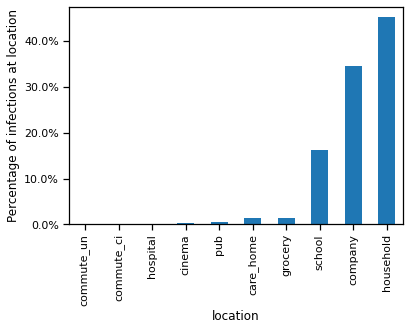

In [107]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')

Text(0.5, 0, 'location')

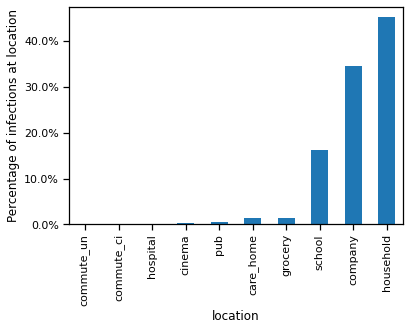

In [108]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')

## rate of infection

In [32]:
read.infections_df

,infected_id,symptoms,n_secondary_infections
time_stamp,,,
2020-03-07 12:00:00,"[6, 42, 235, 531, 790, 809, 890, 1102, 1120, 1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2020-03-08 00:00:00,"[6, 42, 235, 531, 790, 809, 890, 1102, 1120, 1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2020-03-08 12:00:00,"[6, 42, 235, 531, 790, 809, 890, 1102, 1120, 1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2020-03-09 00:00:00,"[6, 42, 235, 531, 790, 809, 890, 1102, 1120, 1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2020-03-09 10:00:00,"[6, 42, 235, 531, 790, 809, 890, 1102, 1120, 1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
2020-07-03 10:00:00,[],[],[]
2020-07-03 12:00:00,[],[],[]
2020-07-04 00:00:00,[],[],[]


In [33]:
r_df = read.get_r()

In [34]:
r_df

,value
time_stamp,
2020-03-07 12:00:00,NaN
2020-03-08 00:00:00,NaN
2020-03-08 12:00:00,NaN
2020-03-09 00:00:00,NaN
2020-03-09 10:00:00,NaN
...,...
2020-07-03 10:00:00,NaN
2020-07-03 12:00:00,NaN
2020-07-04 00:00:00,NaN


Text(0, 0.5, 'R')

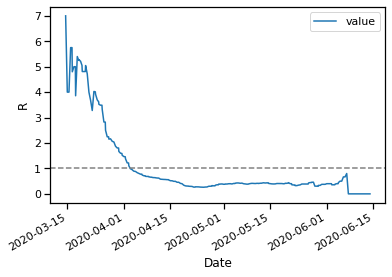

In [35]:
r_df.plot()
plt.axhline(y=1, linestyle='dashed', color='gray')
plt.xlabel('Date')
plt.ylabel('R')

## World infection curves, and by super area

In [36]:
world_df = read.world_summary()

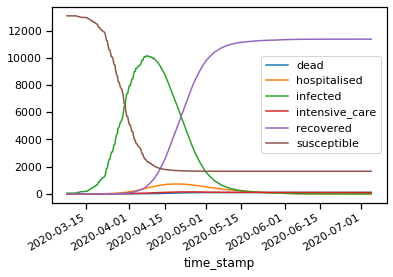

In [131]:
world_df.plot()
plt.legend()

In [132]:
world_df['dead']

time_stamp
2020-03-07 12:00:00      0.0
2020-03-08 00:00:00      0.0
2020-03-08 12:00:00      0.0
2020-03-09 00:00:00      0.0
2020-03-09 10:00:00      0.0
                       ...  
2020-07-03 10:00:00    103.0
2020-07-03 12:00:00    103.0
2020-07-04 00:00:00    103.0
2020-07-04 12:00:00    103.0
2020-07-05 00:00:00    103.0
Name: dead, Length: 325, dtype: float64

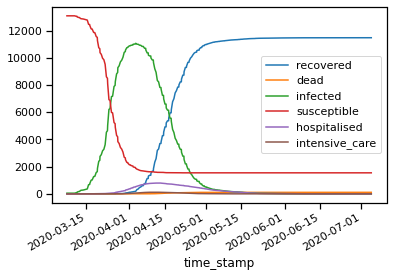

In [37]:
world_df.plot()
plt.legend()

In [38]:
area_df = read.super_area_summary()

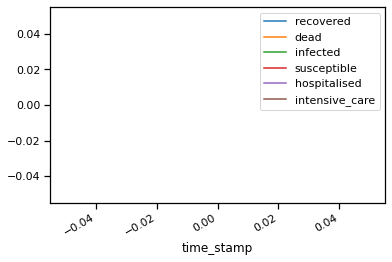

In [39]:
area_df[area_df.super_area == 'E02002560'].plot()
plt.legend()

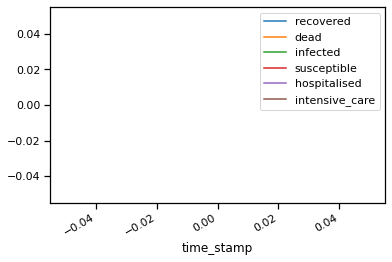

In [40]:
area_df[area_df.super_area == 'E02001720'].plot()
plt.legend()

## World infection curves per age group

In [41]:
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

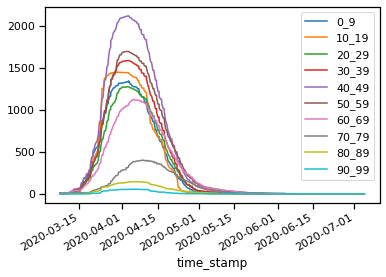

In [42]:
for name, group in ages_df.groupby('age_range'):
    group['infected'].plot(label=name)
plt.legend()

## Draw some of the symptoms trajectories

In [43]:
random_trajectories = read.draw_symptom_trajectories(window_length=100,
                                        n_people=5)

In [46]:
from june.infection import SymptomTag

In [47]:
symptoms_values = [tag.value for tag in SymptomTag]
symptoms_names = [tag.name for tag in SymptomTag]


Text(0.5, 0, 'Date')

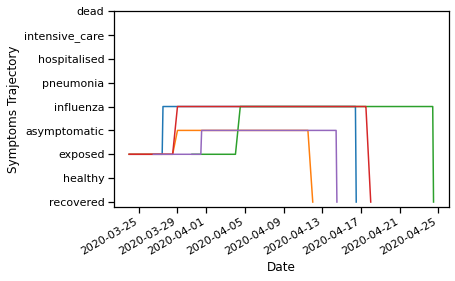

In [48]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
_ = plt.yticks(symptoms_values, symptoms_names)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

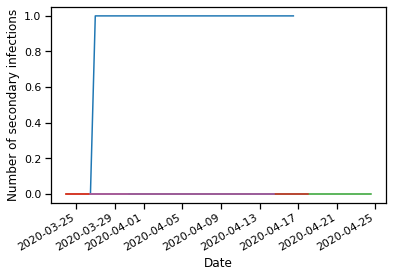

In [49]:
for df_person in random_trajectories:
    df_person['n_secondary_infections'].plot()
plt.ylabel('Number of secondary infections')

plt.xlabel('Date')